In [1]:
import os, torch, csv

import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Check for CUDA GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
# Check for Apple MPS - Comment if causing problems
elif torch.backends.mps.is_available():
    device = torch.device("mps")
# Default to CPU
else:
    device = torch.device("cpu")

In [2]:
class DatasetLoader(Dataset):
    def __init__(self, metadata, img_dir, transform=None, max_per_class=300, target_samples_per_class=3000):
        """
        Args:
            metadata (DataFrame): DataFrame containing image file names and labels.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            max_per_class (int): Maximum images per class for balancing.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(metadata['dx']. unique())}
        self.metadata = self.create_balanced_subset(metadata, max_per_class)
        self.target_samples = target_samples_per_class

    def create_balanced_subset(self, metadata, max_per_class):
        return pd.concat([
            df.sample(n=min(len(df), max_per_class), random_state=42) if len(df) > max_per_class else df
            for _, df in metadata.groupby('dx')
        ]).reset_index(drop=True)

    def __len__(self):
        return int(np.ceil(len(self.metadata) * self.target_samples / self.metadata['dx'].value_counts().min()))
    
    def __getitem__(self, idx):
        actual_idx = idx % len(self.metadata)
        img_name = os.path.join(self.img_dir, self.metadata.iloc[actual_idx, 1] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label_name = self.metadata.iloc[actual_idx, 2]
        label = self.class_to_idx[label_name]
        filename = self.metadata.iloc[actual_idx, 1] + '.jpg'
        
        if self.transform:
            # Apply torchvision transformations
            image = self.transform(image)

        return image, label, filename  # Returning filename here

In [3]:
# Define torchvision transformations
transform = tv.transforms.Compose([
    tv.transforms.Resize((256, 256)),  # Resize the images to 256x256 pixels
    tv.transforms.RandomRotation(degrees=360),  # Random rotation between 0 and 360 degrees
    tv.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.75, 1.25), shear=20),  # Random translation, scaling and shearing
    tv.transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    tv.transforms.ToTensor(),  # Convert to tensor (necessary for input to PyTorch model)
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

In [4]:
img_path = './data/images/'
metadata_path = './data/HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)
dataset = DatasetLoader(metadata, img_path, transform=transform, max_per_class=300, target_samples_per_class=3000)

In [5]:
# Split the dataset 60-20-20
train_size = int(0.6 * len(dataset))
validation_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

860
287
287


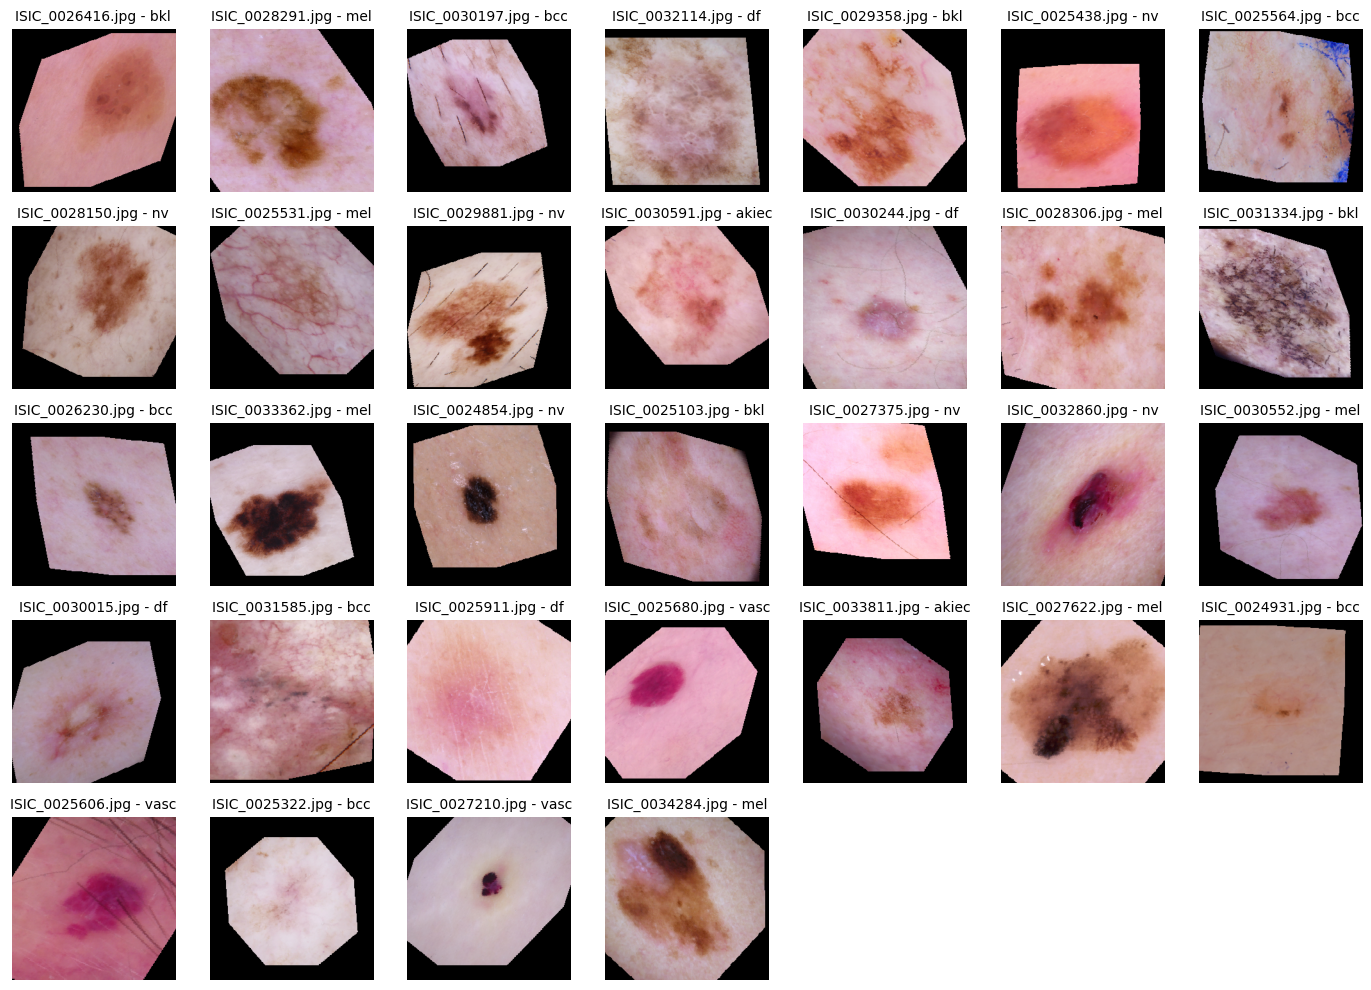

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Custom imshow for displaying images."""
    inp = inp.numpy().transpose((1, 2, 0))  # Re-arrange dimensions to Height x Width x Channels
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)  # Set the title with a smaller font size
    plt.axis('off')  # Turn off axis labels

def show_images(inputs, classes, filenames, class_names, nrow=10):
    """Display a batch of images in a dense grid."""
    num_images = inputs.size(0)
    ncols = nrow
    nrows = (num_images + nrow - 1) // nrow

    fig = plt.figure(figsize=(2*nrow, 2*nrows))

    for idx in range(num_images):
        ax = fig.add_subplot(nrows, ncols, idx + 1, xticks=[], yticks=[])
        imshow(inputs[idx], f"{filenames[idx]} - {class_names[classes[idx]]}")

    plt.tight_layout()
    plt.show()

inputs, classes, filenames = next(iter(train_loader))
class_names = metadata['dx'].unique().tolist()

show_images(inputs, classes, filenames, class_names, nrow=7)  # Adjust 'nrow' to fit your screen size and preference


In [7]:
class RegNetYBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=1):
        super(RegNetYBlock, self).__init__()
        # Assuming use of bottleneck blocks with a reduction at the beginning
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        out = F.relu(out)

        return out

class RegNetY320(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(RegNetY320, self).__init__()
        self.in_channels = 32  # Initial number of channels
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Example of layer configuration, actual values should be based on the RegNetY-320 config
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2, groups=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, groups=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, groups=4)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, groups=8)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)  # Correct the input feature size here

        
    def _make_layer(self, block, out_channels, blocks, stride, groups):
        layers = [block(self.in_channels, out_channels, stride, groups)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, groups=groups))

        return nn.Sequential(*layers)

    def forward(self, x):
        # print(f"Initial input shape: {x.shape}")  # Debugging: Check initial shape

        x = self.conv1(x)
        # print(f"After conv1 (Conv2d): {x.shape}")  # Debugging: Shape after first Conv2D
        x = self.bn1(x)
        # print(f"After bn1 (BatchNorm2d): {x.shape}")  # Debugging: Shape after first BatchNorm
        x = self.relu(x)
        # print(f"After relu (ReLU): {x.shape}")  # Debugging: Shape after ReLU activation
        x = self.maxpool(x)
        # print(f"After maxpool (MaxPool2d): {x.shape}")  # Debugging: Shape after MaxPooling

        x = self.layer1(x)
        # print(f"After layer1: {x.shape}")  # Debugging: Shape after layer 1
        x = self.layer2(x)
        # print(f"After layer2: {x.shape}")  # Debugging: Shape after layer 2
        x = self.layer3(x)
        # print(f"After layer3: {x.shape}")  # Debugging: Shape after layer 3
        x = self.layer4(x)
        # print(f"After layer4: {x.shape}")  # Debugging: Shape after layer 4

        x = self.avgpool(x)
        # print(f"After avgpool (AdaptiveAvgPool2d): {x.shape}")  # Debugging: Shape after Adaptive Avg Pooling
        x = torch.flatten(x, 1)
        # print(f"After flatten (Flatten): {x.shape}")  # Debugging: Shape after flattening
        x = self.fc(x)
        # print(f"Final output shape (after fc): {x.shape}")  # Debugging: Final shape after fully connected layer


        return x


# Assuming "layers" is a list that contains the number of blocks in each stage
model = RegNetY320(RegNetYBlock, layers=[3, 4, 6, 3], num_classes=7)


In [9]:
model.to(device)
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

# Dictionaries to store metrics
training_stats = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    training_stats['train_loss'].append(train_loss / len(train_loader.dataset))
    training_stats['train_accuracy'].append(train_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {training_stats["train_loss"][-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels, _ in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    training_stats['val_loss'].append(val_loss / len(validation_loader.dataset))
    training_stats['val_accuracy'].append(val_accuracy)
    
    print(f'Validation Loss: {training_stats["val_loss"][-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Using device: mps
Epoch 1/20 - Train Loss: 1.3385, Train Accuracy: 49.20%
Validation Loss: 1.2004, Validation Accuracy: 52.23%
Epoch 2/20 - Train Loss: 1.0924, Train Accuracy: 58.50%
Validation Loss: 1.0943, Validation Accuracy: 57.72%
Epoch 3/20 - Train Loss: 0.9562, Train Accuracy: 63.26%
Validation Loss: 0.8504, Validation Accuracy: 67.51%
Epoch 4/20 - Train Loss: 0.8550, Train Accuracy: 67.68%
Validation Loss: 0.7056, Validation Accuracy: 73.55%
Epoch 5/20 - Train Loss: 0.7732, Train Accuracy: 70.40%
Validation Loss: 0.7904, Validation Accuracy: 69.30%
Epoch 6/20 - Train Loss: 0.6980, Train Accuracy: 73.48%
Validation Loss: 0.5694, Validation Accuracy: 78.78%
Epoch 7/20 - Train Loss: 0.6270, Train Accuracy: 76.04%
Validation Loss: 0.5915, Validation Accuracy: 77.43%
Epoch 8/20 - Train Loss: 0.5588, Train Accuracy: 78.46%
Validation Loss: 0.5265, Validation Accuracy: 79.62%
Epoch 9/20 - Train Loss: 0.5055, Train Accuracy: 80.74%
Validation Loss: 0.6920, Validation Accuracy: 75.77%
E

In [ ]:
def save_training_stats(training_stats, filename="training_stats.csv"):
    csv_columns = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
    try:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            writer.writeheader()
            for data in zip(*[training_stats[key] for key in csv_columns]):
                writer.writerow(dict(zip(csv_columns, data)))
    except IOError:
        print("I/O error during CSV file writing")

def plot_training_stats(filename="training_stats.csv"):
    df = pd.read_csv(filename)

    plt.figure(figsize=(10, 5))
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(df['epoch'], df['train_accuracy'], label='Train Accuracy')
    plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

save_training_stats(training_stats)
plot_training_stats()

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct / total
    print(f'Test Loss: {average_test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
    return average_test_loss, test_accuracy

test_model(model, test_loader, criterion=criterion, device=device)

In [ ]:
mps_available = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()

print(mps_available)